In this project the following paper served as guidance:

Evidence for the utility of quantum computing before fault tolerance. Nature, 615(7950), 596-600

This paper discusses the experimental evidence for the utility of quantum computing before achieving fault tolerance. The authors conducted experiments on a 127-qubit superconducting quantum processor, demonstrating that it can accurately measure expectation values for quantum circuits at a scale beyond what is feasible with brute-force classical computation. This suggests that quantum computing can offer advantages even in the current, noisy era, prior to the development of fully fault-tolerant quantum computers.

The study focuses on running quantum circuits related to the time evolution of a 2D transverse-field Ising model. These circuits involve significant entanglement, making them challenging for classical methods to simulate accurately. The authors argue that this work provides a foundational tool for the realization of near-term quantum applications, showing that current quantum processors can be reliable enough to perform meaningful computations at scales unattainable by classical methods.

**Reference:**
Kim, Y., Eddins, A., Anand, S., Wei, K. X., van den Berg, E., Rosenblatt, S., Nayfeh, H., Wu, Y., Zaletel, M., Temme, K., & Kandala, A. (2023). Evidence for the utility of quantum computing before fault tolerance. *Nature*, *615*(7950), 596-600. https://doi.org/10.1038/s41586-023-06096-3

The base 2D-Ising model is derived from the 1D version displayed in the classiq-library on github:
    
    https://github.com/Classiq/classiq-library/blob/main/applications/physical_systems/ising_model/ising_model.ipynb 
authored by Amir Naveh.

In this project a noiseless 2D Ising model is presented. It is then trotterized, noise is added to it and zero noise extrapolation applied. It is also run with depth and width constraints.

# The Ising Model

The Ising model is a pivotal concept in physics, originally developed to describe interactions between atomic spins in a lattice. While its initial focus was on magnetic dipole moments, the model's applications have expanded far beyond its origins. Today, it is instrumental in understanding phenomena in various fields, including neural networks, spin glasses, and the study of phase transitions.

At its heart, the Ising model is defined by a Hamiltonian that captures the energy of a system based on the interactions between neighboring spins. The model is notable for its ability to represent complex systems with simple binary variables, making it a powerful tool in both theoretical and applied physics. Additionally, the Ising model serves as a foundation for solving intricate optimization problems. Its formulation as a Quadratic Unconstrained Binary Optimization (QUBO) problem allows it to be mapped onto various NP-hard challenges, such as the traveling salesman problem or protein folding.

Using the Classiq platform, we demonstrate how the Ising model can be transformed into an optimization problem suitable for quantum computation. By employing Classiq's quantum approximate optimization algorithm (QAOA), we can approach the solution through quantum simulation. This method is versatile and can be adapted to run on different quantum simulators or even actual quantum hardware, showcasing the potential of quantum computing in addressing highly complex and computationally demanding problems.

# 2-D Ising Model 

## 0. Pre-requisites
We need to ensure we have the required libraries:

In [1]:
%pip install -q --upgrade pip 

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -q pyomo
%pip install -q classiq 
%pip install -q matplotlib 

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-ibm-runtime 0.25.0 requires pydantic>=2.5.0, but you have pydantic 1.10.17 which is incompatible.
qc-grader 0.19.7 requires networkx==3.2.1, but you have networkx 2.8.8 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pyomo.core as pyo
from classiq import * 
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq import set_execution_preferences, write_qmod, show, synthesize, execute
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
import pandas as pd
from classiq.applications.combinatorial_optimization import get_optimization_solution_from_pyo


### 1. Defining the Optimization Problem


In this step, we will build a 2D Ising model, which is a widely-used model for understanding the interactions of spins on a lattice. Each spin in this model can be either +1 or -1, representing two possible states.

The Ising model describes how these spins interact with each other and with an external magnetic field. Specifically, you will define two key parameters:

- **Interaction Coupling (J):** This parameter controls how strongly neighboring spins influence each other. If \( J \) is positive, the spins tend to align in the same direction (ferromagnetic interaction). If \( J \) is negative, the spins prefer to align in opposite directions (antiferromagnetic interaction).
  
- **Magnetic Field (h):** This parameter represents an external magnetic field that affects each spin individually, encouraging them to align with the field.

In this model, the user has the option to apply **periodic boundary conditions**. This means that the edges of the lattice are connected, so the spins on the edge interact with the spins on the opposite edge. This setup simulates an infinite lattice by avoiding edge effects and ensuring that each spin has the same number of neighbors.

By choosing the values for \( J \) and \( h \), and deciding whether to use periodic boundary conditions, you can explore how different physical conditions affect the behavior of the system. This is particularly useful for studying phenomena like phase transitions and the overall magnetization of the system.



In [2]:
def ising_model_2d(J: int, h: int, rows: int, cols: int, periodic: str) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("ising_2d")

    # Define the variables:
    model.z = pyo.Var(range(rows * cols), domain=pyo.Binary)
    z_array = np.array(list(model.z.values())).reshape((rows, cols))

    def E(i, j, k, l):
        return -J * (2 * z_array[i, j] - 1) * (2 * z_array[k, l] - 1) - (h / 2) * (
            (2 * z_array[i, j] - 1) + (2 * z_array[k, l] - 1)
        )

    # Create the Ising Hamiltonian
    model.H = 0
    for i in range(rows):
        for j in range(cols):
            if j + 1 < cols:
                model.H += E(i, j, i, j + 1)
            if i + 1 < rows:
                model.H += E(i, j, i + 1, j)
            if periodic == "True":
                if j == cols - 1:
                    model.H += E(i, j, i, 0)
                if i == rows - 1:
                    model.H += E(i, j, 0, j)

    # Setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    return model


## 2. Create the 2D Ising model
Instantiate the 2D Ising model with the chosen parameters: 
- coupling J
- magnetic field h
- boundary conditions periodic or not

In [6]:
ising_model = ising_model_2d(J=10, h=-20, rows=4, cols=4, periodic="True")


## 3. Optimize Using Quantum Optimization Algorithm
Set up and run the optimization using QAOA:
Next, we will develop a QAOA (Quantum Approximate Optimization Algorithm) model to solve the optimization problem. The output of this model will be the sequence of qubit values that represent the spin system's configuration with the lowest energy state.

In [7]:
qaoa_config = QAOAConfig(num_layers=5)
optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)

qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)
write_qmod(qmod, "ising_model_2d")

constraints = Constraints(max_width = 100, optimization_parameter = "depth")
qmod = set_constraints(qmod,constraints=constraints)
qprog = synthesize(qmod)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for depth")
print(f"The circuit composition is:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod = set_constraints(qmod,constraints=constraints)
qprog = synthesize(qmod)
#show(qprog)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for width")
print(f"The circuit composition is:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

res = execute(qprog).result()


The circuit width is 16 and the circuit_depth is 91 when optimized for depth
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
The circuit width is 16 and the circuit_depth is 91 when optimized for width
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


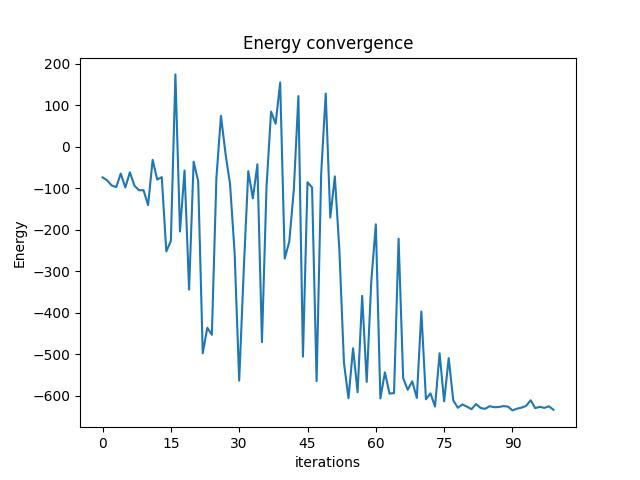

In [8]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph


After about 76 iterations a stable solution is  found. The number of qubits needed depends on the number of spins of the system. 

## 4. Present Quantum Results
Retrieve and present the optimization results: 
Since this is a quantum solution with probabilistic results, there is a defined probability for each result to be obtained by a measurement (presented by an histogram), where the solution is chosen to be the most probable one.

We remind that in the notation of the solution "0" indicate "-1" spin value, and "1" indicates "1" spin value.

In [11]:
vqe_result = res[0].value

solution = get_optimization_solution_from_pyo(
    ising_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)


,probability,cost,solution,count
0,0.146484,-960.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",300
1,0.013184,-800.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",27
2,0.012207,-800.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",25
13,0.008301,-800.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",17
14,0.007324,-800.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",15


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

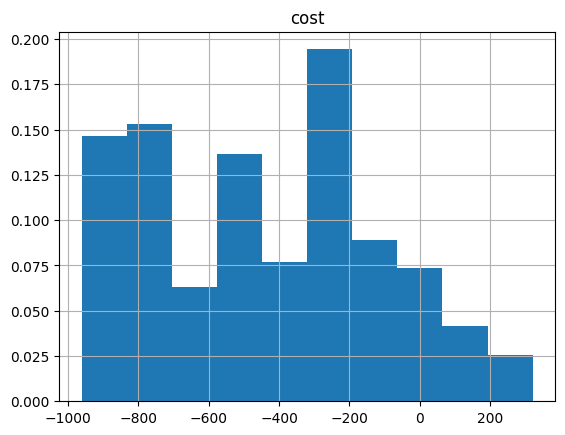

In [12]:
optimization_result.hist("cost", weights=optimization_result["probability"])

## 2D Ising Model Ground State Energy

Calculating the exact ground state energy for a 2D Ising model using brute-force enumeration involves iterating over all possible spin configurations for a 2D grid. Given the exponential growth in the number of configurations, this approach is feasible only for small grids. Below is the Python code for this approach:

### Brute-force Enumeration Method for 2D Ising Model

In [9]:
import numpy as np
from itertools import product

def calculate_ising_energy_2d(spins, J, h, L, periodic):
    energy = 0
    for i in range(L):
        for j in range(L):
            S = spins[i][j]
            if i < L - 1:  # Interaction with right neighbor
                energy -= J * S * spins[i + 1][j]
            elif periodic:  # Periodic boundary interaction
                energy -= J * S * spins[0][j]
            if j < L - 1:  # Interaction with bottom neighbor
                energy -= J * S * spins[i][j + 1]
            elif periodic:  # Periodic boundary interaction
                energy -= J * S * spins[i][0]
            energy -= h * S  # Magnetic field contribution
    return energy

def ising_model_2d_exact(J, h, L, periodic=True):
    # Generate all possible spin configurations for an LxL grid
    all_spins = product([-1, 1], repeat=L*L)
    
    ground_state_energy = float('inf')
    ground_state_configuration = None
    
    for spins in all_spins:
        spins = np.array(spins).reshape((L, L))
        energy = calculate_ising_energy_2d(spins, J, h, L, periodic)
        if energy < ground_state_energy:
            ground_state_energy = energy
            ground_state_configuration = spins
    
    return ground_state_energy, ground_state_configuration

# Example usage
J = 1
h = -2
L = 4
periodic = True

ground_state_energy, ground_state_configuration = ising_model_2d_exact(J, h, L, periodic)
print("Ground State Energy (2D):", ground_state_energy)
print("Ground State Configuration:")
print(ground_state_configuration)


Ground State Energy (2D): -64
Ground State Configuration:
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]


## Explanation:
calculate_ising_energy_2d: This function calculates the energy of a given spin configuration for a 2D grid. It sums the interaction terms between neighboring spins and the contribution from the magnetic field. If the periodic boundary condition is specified, it also includes interactions across the boundaries.
ising_model_2d_exact: This function generates all possible spin configurations for an 
𝐿
×
𝐿
L×L grid. It then calculates the energy of each configuration using calculate_ising_energy_2d and keeps track of the configuration with the lowest energy (ground state).
## Example Usage:
We specify the interaction coupling 
𝐽
J, the magnetic field 
ℎ
h, the size of the grid 
𝐿
L, and whether the boundary conditions are periodic.
The function ising_model_2d_exact computes the ground state energy and the corresponding spin configuration by brute-force enumeration.

## Limitations:
This brute-force approach is computationally expensive and feasible only for small grids (e.g., 
𝐿
≤
4
L≤4). For larger grids, the number of configurations grows exponentially, making this method impractical.
For larger systems, more advanced techniques such as Monte Carlo simulations or optimization algorithms should be used.

To show a convergence graph for the ground state energy of the 2D Ising model, we can use an iterative optimization algorithm instead of brute-force enumeration. One common approach is to use simulated annealing or a similar heuristic optimization method, which iteratively improves the solution.



# Trotterization 

Trotterization is a method in quantum computing used to approximate the evolution of complex quantum systems. It simplifies the process by breaking down the system's evolution into smaller, manageable steps. This allows us to simulate quantum behaviors on quantum computers, such as chemical reactions or material properties.

By alternating between different interactions in small intervals, Trotterization helps approximate the system's overall behavior. Although it introduces some errors, these can be reduced by increasing the number of steps, making the simulation more accurate. In short, Trotterization is crucial for making complex quantum simulations feasible on quantum computers.

To incorporate Trotterization into the 2D Ising model for quantum optimization,  need to follow these steps:

## Update the Ising Model for Trotterization:

Trotterization involves approximating the time evolution operator by decomposing it into simpler, smaller steps. For the Ising model, this usually means breaking down the Hamiltonian into parts and approximating the evolution operator with a series of these smaller steps.

## Construct the Quantum Optimization Model:

We use the Trotterized Hamiltonian in our quantum optimization model.
Here’s how you can update your code to include Trotterization and prepare the model for QAOA optimization:


# Steps:

## 1. Hamiltonian Construction with Trotterization:

The hamiltonian function calculates the Hamiltonian of the Ising model, taking into account Trotterization by dividing the Hamiltonian by the number of Trotter steps.

## 2. Quantum Optimization Setup:

The construct_combinatorial_optimization_model function prepares the model for quantum optimization using QAOA.

## 3. Backend and Execution:

The backend preferences and execution setup ensure that the model is run on the chosen quantum simulator.

## 4. Convergence Graph:

After running the optimization, the convergence graph helps visualize how the optimization process evolves.
This code allows us to include Trotterization in the quantum optimization of the 2D Ising model, using QAOA and a quantum simulator.

To include Trotterization for the 2D Ising model, we need to decompose the Hamiltonian into smaller steps. For simplicity, we'll assume a straightforward Trotterization approach, where we split the Hamiltonian into two parts: the interaction terms and the magnetic field terms. Here's how we can modify our 2D Ising model to include Trotterization:

## Updated 2D Ising Model with Trotterization

In [13]:
import pyomo.environ as pyo
import numpy as np
from pyomo.core import ConcreteModel

def ising_model_2d(J: int, h: int, rows: int, cols: int, periodic: str, trotter_steps: int) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("ising_2d")

    # Define the variables
    model.z = pyo.Var(range(rows * cols), domain=pyo.Binary)
    z_array = np.array(list(model.z.values())).reshape((rows, cols))

    # Helper function to get spin value
    def get_spin(i, j):
        return 2 * z_array[i, j] - 1

    # Interaction term
    def interaction_term(i, j, k, l):
        return -J * get_spin(i, j) * get_spin(k, l)

    # Magnetic field term
    def magnetic_field_term(i, j):
        return -h * get_spin(i, j)

    # Define the Hamiltonian with Trotterization
    def hamiltonian(periodic, trotter_steps):
        H_interaction = 0
        H_magnetic = 0
        
        # Interaction terms
        for i in range(rows):
            for j in range(cols):
                if j + 1 < cols:
                    H_interaction += interaction_term(i, j, i, j + 1)
                if i + 1 < rows:
                    H_interaction += interaction_term(i, j, i + 1, j)
                if periodic == "True":
                    if j == cols - 1:
                        H_interaction += interaction_term(i, j, i, 0)
                    if i == rows - 1:
                        H_interaction += interaction_term(i, j, 0, j)
        
        # Magnetic field terms
        for i in range(rows):
            for j in range(cols):
                H_magnetic += magnetic_field_term(i, j)
        
        # Trotterization
        H_total = (H_interaction + H_magnetic) / trotter_steps
        return H_total

    # Create the Hamiltonian with Trotterization
    model.H = hamiltonian(periodic, trotter_steps)

    # Set the objective
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    return model

In [14]:
# Parameters
J = 10
h = -20
rows = 4
cols = 4
periodic = "True"
trotter_steps = 10  # Number of Trotter steps

### 2. Create Your 2D Ising Model
Instantiate the 2D Ising model with the chosen parameters:


In [15]:
# Create Ising model
ising_model = ising_model_2d(J, h, rows, cols, periodic, trotter_steps)


### 3. Optimize Using Quantum Optimization Algorithm
Set up and run the optimization using QAOA:


The circuit width is 16 and the circuit_depth is 91 when optimized for depth
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
The circuit width is 16 and the circuit_depth is 91 when optimized for width
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


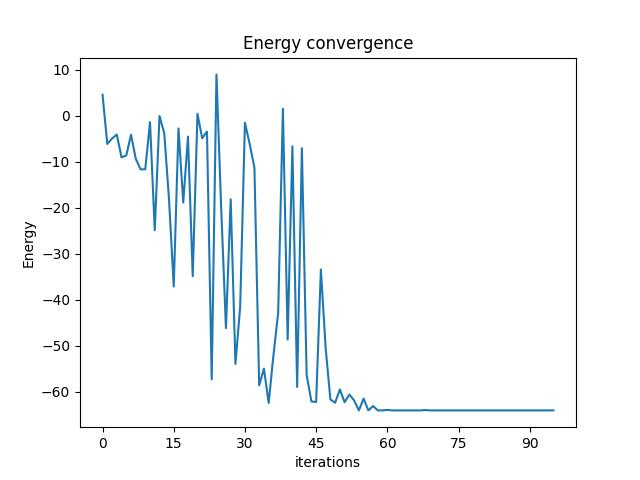

In [16]:
# Quantum optimization with QAOA
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5)
optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)

qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

# Set quantum backend
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

# Write the QAOA model
from classiq import write_qmod
write_qmod(qmod, "ising_model_2d_trotter")

# Create and show the quantum circuit
from classiq import show, synthesize

constraints = Constraints(max_width = 100, optimization_parameter = "depth")
qmod = set_constraints(qmod,constraints=constraints)
qprog = synthesize(qmod)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for depth")
print(f"The circuit composition is:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod = set_constraints(qmod,constraints=constraints)
qprog = synthesize(qmod)
#show(qprog)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for width")

print(f"The circuit composition is:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

# Execute the quantum program
from classiq import execute
res = execute(qprog).result()

# Check the convergence graph
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph


Convrgence happens with the trotterized system after about 60 iterations, which is quicker than with the non-trotterized system.

In [ ]:
ibm_provider = IBMBackendProvider(
    hub="Hub name", group="Group name", Project="Project name"
)
ibm_preferences = IBMBackendPreferences(
    backend_name="Name of requsted quantum hardware",
    access_token="A Valid API access token to IBM Quantum",
    provider=ibm_provider,
)
execution_preferences = ExecutionPreferences(
    backend_preferences=ibm_preferences
)

# Set the preferences
model = set_execution_preferences(model, execution_preferences)

# Create the model
model = create_model(main)

In [ ]:
constraints = Constraints(
    max_width=20, optimization_parameter=OptimizationParameter.DEPTH
)
model = set_constraints(model, constraints)


quantum_model_with_preferences = set_preferences(
    quantum_model,
    Preferences(backend_service_provider="IBM Quantum", backend_name="ibm_brisbane"),
)

In [ ]:
model = create_model(main)
constraints = Constraints(
    optimization_parameter=OptimizationParameter.DEPTH, max_width=21
)
preferences = Preferences(
    backend_service_provider="IBM Quantum", backend_name="ibmq_kolkata"
)
model = set_constraints(model, constraints)
model = set_preferences(model, preferences)

write_qmod(model, "mcx_14_ctrl_hardware")


In [ ]:
from classiq.execution import IBMBackendPreferences, IBMBackendProvider

ibm_provider = IBMBackendProvider()

preferences = IBMBackendPreferences(
    backend_name="ibmq_lima",
    access_token="insert_token_number",
    provider=ibm_provider,
)

In [ ]:
from classiq.execution import IBMBackendPreferences, IBMBackendProvider

ibm_provider = IBMBackendProvider()

preferences = IBMBackendPreferences(
    backend_name="ibmq_quito",
    access_token="insert_token_number",
    provider=ibm_provider,
)

In [ ]:
from classiq.execution import IBMBackendPreferences, IBMBackendProvider

ibm_provider = IBMBackendProvider()

preferences = IBMBackendPreferences(
    backend_name="ibmq_manila",
    access_token="insert_token_number",
    provider=ibm_provider,
)
